<a href="https://colab.research.google.com/github/lizhieffe/language_model/blob/main/Let's_build_GPT_from_scratch%2C_in_code%2C_spelled_out.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.youtube.com/watch?v=kCc8FmEb1nY

# Setup

In [ ]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt


--2023-10-01 05:22:37--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.02s   

2023-10-01 05:22:37 (46.2 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [ ]:
with open('input.txt', 'r', encoding='utf-8') as f:
  text = f.read()

In [ ]:
print(f'len of dataset in cahr: {len(text)}')

len of dataset in cahr: 1115394


In [ ]:
print(f'first 1000 chars:\n\n{text[:1000]}')

first 1000 chars:

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in th

In [ ]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(f'vocab size = {vocab_size}')


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
vocab size = 65


# Tokenizers

- The one in this section is a very simple one.
- A proper tokenizer usually uses sub-word tokenizer
  - Google uses `SentencePiece`
  - OpenAI uses `tiktoken`
  - sub-word tokenizer has a *larger vocabulary* and generates a *shorter sequence of tokens* for a given text

In [ ]:
# create a map from chars to integers
stoi = { ch:i for i,ch in enumerate(chars)}
itos = { i:ch for i,ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode('hii there'))
print(decode(encode('hii there')))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [ ]:
encoded_text = encode(text)
print(f'size of encoded_text = {len(encoded_text)}')

size of encoded_text = 1115394


In [ ]:
print(decode([0]))

In [ ]:
import torch
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:1000])

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
      

# Dataset

In [ ]:
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

## Max context length

- When training, chucks of train_data is feed into the model with a max length.
- `block_size` is the max context length. It may have different name in other work, like `context_size`
- It is called "context" because the decoder predicts the next token based on the context tokens

In [ ]:
block_size = 8
train_data[:block_size+1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

For each chunk, it contains multiple examples implicitly, because of the sequence nature of the model.

For example
- c[0]->c[1]
- c[0],c[1]->c[2]
- ...

This can help the model to get used to different length of inputs.

In [ ]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
  print(f'input = {x[:t+1]}, target = {y[t]}')

input = tensor([18]), target = 47
input = tensor([18, 47]), target = 56
input = tensor([18, 47, 56]), target = 57
input = tensor([18, 47, 56, 57]), target = 58
input = tensor([18, 47, 56, 57, 58]), target = 1
input = tensor([18, 47, 56, 57, 58,  1]), target = 15
input = tensor([18, 47, 56, 57, 58,  1, 15]), target = 47
input = tensor([18, 47, 56, 57, 58,  1, 15, 47]), target = 58


## Batch

In [ ]:
torch.manual_seed(1337)
batch_size = 4
block_size = 8

def get_batch(split):
  # generate a small batch of data of inputs x and targets y
  data = train_data if split == 'train' else val_data
  ix = torch.randint(len(data) - block_size, (batch_size,))
  x = torch.stack([data[i:i+block_size] for i in ix])
  y = torch.stack([data[i+1:i+block_size+1] for i in ix])
  return x, y

xb, yb = get_batch('train')
print(f'inputs shape = {xb.shape}')
print(f'inputs = {xb}')
print(f'targets shape = {yb.shape}')
print(f'targets = {yb}')

print('-------------')

for b in range(batch_size): # batch dim
  for t in range(block_size): # time dim
    context = xb[b, :t+1]
    target = yb[b, t]
    print(f'when input is {context}, target is {target}')

inputs shape = torch.Size([4, 8])
inputs = tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets shape = torch.Size([4, 8])
targets = tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
-------------
when input is tensor([24]), target is 43
when input is tensor([24, 43]), target is 58
when input is tensor([24, 43, 58]), target is 5
when input is tensor([24, 43, 58,  5]), target is 57
when input is tensor([24, 43, 58,  5, 57]), target is 1
when input is tensor([24, 43, 58,  5, 57,  1]), target is 46
when input is tensor([24, 43, 58,  5, 57,  1, 46]), target is 43
when input is tensor([24, 43, 58,  5, 57,  1, 46, 43]), target is 39
when input is tensor([44]), target is 53
when input is tensor([44, 53]), target is 56
when input is tensor([44, 53, 56]), 

# Define Model - Simple Bigram Model

It uses only *one previous token* as context to generate the next token.

It uses **previous** context only, but not **future** context, because this is a "**docoder**" model which runs in auto-regressive fashion. For "**encoder**" model, it can use both directions.

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):
  '''Predict by using context with size = 1'''

  def __init__(self, vocab_size):
    super().__init__()
    # each token directly reads off the logits for the next token from a lookup table
    self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

  def forward(self, idx, targets=None):
    # idx and targets are both (B, T) tensor of integers
    logits = self.token_embedding_table(idx)  # (B, T, C)

    if targets is None:
      loss = None
    else:
      B, T, C = logits.shape
      logits = logits.view(B*T, C)
      targets = targets.view(B*T)
      loss = F.cross_entropy(logits, targets)

    return logits, loss

  # idx will transite from (B, T) to (B, T+max_new_tokens)
  def generate(self, idx, max_new_tokens):
    # idx is (B, T) array of indices in the current context
    for _ in range(max_new_tokens):
      # get the predictions by calling forward() method
      logits, loss = self(idx)
      # focus on only the last timestamps
      logits = logits[:, -1, :] # becomes (B, C)
      # apply softmax to get probabilities
      probs = F.softmax(logits, dim=-1) # (B, C)
      # sample from the distribution
      idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
      # append sampled index to the running sequence
      idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)

    return idx


m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print(f'logits shape = {logits.shape}')
print(f'logits = {logits}')

print(f'loss shape = {loss.shape}')
print(f'loss = {loss}')

logits shape = torch.Size([32, 65])
logits = tensor([[-1.5101, -0.0948,  1.0927,  ..., -0.6126, -0.6597,  0.7624],
        [ 0.3323, -0.0872, -0.7470,  ..., -0.6716, -0.9572, -0.9594],
        [ 0.2475, -0.6349, -1.2909,  ...,  1.3064, -0.2256, -1.8305],
        ...,
        [-2.1910, -0.7574,  1.9656,  ..., -0.3580,  0.8585, -0.6161],
        [ 0.5978, -0.0514, -0.0646,  ..., -1.4649, -2.0555,  1.8275],
        [-0.6787,  0.8662, -1.6433,  ...,  2.3671, -0.7775, -0.2586]],
       grad_fn=<ViewBackward0>)
loss shape = torch.Size([])
loss = 4.878634929656982


### Try the model

The result is completely random, because the model is not trained

In [ ]:
# 0, which is new line char, is a reasonable start (seed) char
idx = torch.zeros((1,1), dtype=torch.long)
decode(m.generate(idx, max_new_tokens=100)[0].tolist())

"\nSr?qP-QWktXoL&jLDJgOLVz'RIoDqHdhsV&vLLxatjscMpwLERSPyao.qfzs$Ys$zF-w,;eEkzxjgCKFChs!iWW.ObzDnxA Ms$3"

# Training

- Relatively large learning rate is good for smaller model; a relatively small LR is good for bigger model


## Optimizer

In [ ]:
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

## Define Training Loop

In [ ]:
batch_size = 32

for steps in range(100):
  # Sample a batch of data
  xb, yb = get_batch('train')

  # evaluate the loss
  logits, loss = m(xb, yb)
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()

print(loss.item())

4.587916374206543


In [ ]:
decode(m.generate(idx, max_new_tokens=300)[0].tolist())

"\nxiKi-RJ:CgqVuUa!U?qMH.uk!sCuMXvv!CJFfx;LgRyJknOEti.?I&-gPlLyulId?XlaInQ'q,lT$\n3Q&sGlvHQ?mqSq-eON\nx?SP fUAfCAuCX:bOlgiRQWN:Mphaw\ntRLKuYXEaAXxrcq-gCUzeh3w!AcyaylgYWjmJM?Uzw:inaY,:C&OECW:vmGGJAn3onAuMgia!ms$Vb q-gCOcPcUhOnxJGUGSPJWT:.?ujmJFoiNL&A'DxY,prZ?qdT;hoo'dHooXXlxf'WkHK&u3Q?rqUi.kz;?Yx?C&u3Qbfzx"

# The mathematical trick in self-attention

In the previous example, we uses the Bigram LM, which uses only one previous token to predict the next token.

Here, we switch to a more complicated attention to make the context to cover **all previous tokens**. Note that it doesn't cover the *future* tokens because that are to be predicted.

In [ ]:
# Consider this toy example

torch.manual_seed(1337)
B,T,C=4,8,2 # batch, time, channels
x = torch.randn(B, T, C)
x.shape

torch.Size([4, 8, 2])

## Version 1: An in-efficient implementation

In [ ]:
# The easiest way to make the token at T to communicate with the previous tokens is avg

# `bow` means bag-of-words, and usually refers to *average*
xbow = torch.zeros((B, T, C))
for b in range(B):
  for t in range(T):
    xprev = x[b, :t+1] # (t, C)
    xbow[b, t] = torch.mean(xprev, 0)

print(f'x[0] = {x[0]}')
print(f'xbow[0] = {xbow[0]}')

x[0] = tensor([[ 0.1808, -0.0700],
        [-0.3596, -0.9152],
        [ 0.6258,  0.0255],
        [ 0.9545,  0.0643],
        [ 0.3612,  1.1679],
        [-1.3499, -0.5102],
        [ 0.2360, -0.2398],
        [-0.9211,  1.5433]])
xbow[0] = tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        [ 0.1490, -0.3199],
        [ 0.3504, -0.2238],
        [ 0.3525,  0.0545],
        [ 0.0688, -0.0396],
        [ 0.0927, -0.0682],
        [-0.0341,  0.1332]])


In [ ]:
x[0].shape

torch.Size([8, 32])

## Version 2: The Trick - a more efficient implementation

The previous impl uses iterations, and not efficient.

This section implements an efficient implementation using matrix operations.

Averaging all timestamp is straightforward, however, averaging only the previous timestamp needs trick. It needs this special handling to ignore the later tokens are because in the data setup, the context and target are of the same shape (B, T), which means on each T (timestamp), it predicts a result. In other words, for one single example at `[b, :]` (at a single batch index), the one example is reused T-dim times to produces T-dim predictions, the 1st is `context[b,0:1]`---->`target[b,0]`, 2nd is `context[b,0:2]`---->`target[b,1]`, 3rd is `context[b,0:3]`---->`target[b,2]`, .... The lower triangle mask hides the elements in the middle of "T-dim times"

This is done by using `tril()` + `ones()`, so that the lower triangular part of a unit matrics can be obtained. It helps to average only the previous timestamps.

In [ ]:
torch.manual_seed(42)

# unit matrix with only lower triangular part; other part are 0.
a = torch.tril(torch.ones(3, 3))

# normalize: make the sum along axis 1 equal to 1
a = a / torch.sum(a, 1, keepdim=True)

b = torch.randint(0, 10, (3,2)).float()
c = a @ b

print(f'a = \n{a}\nb = \n{b}\nc = \n{c}')

a = 
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
b = 
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
c = 
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


In [ ]:
# weight
wei = torch.tril(torch.ones(T, T))
wei = wei / wei.sum(1, keepdim=True)

# wei is (T, T), when multiply with x which is (B, T, C), it will automatically apply B dim at the beginning
# So it will be (B, T, T) @ (B, T, C)
xbow2 = wei @ x # (B, T, T) @ (B, T, C) -----> (B, T, C)

In [ ]:
# xbow and xbow2 should be very close to each other
assert(torch.allclose(xbow, xbow2))

## Version 3: Trick with similar idea, use Softmax

The idea is similar to Version 2, that **a weight matrix is used to make the interaction happens between the current token to only the previous tokens**

The implementation is different, that we use the `softmax()` to help generate the normalized lower triangular unit matrix

In [ ]:
tril = torch.tril(torch.ones(T, T))
wei = torch.zeros(T, T)
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)
xbow3 = wei @ x

print(f'tril = {tril}')
print(f'wei = {wei}')

tril = tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])
wei = tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])


In [ ]:
# xbow and xbow3 should be very close to each other
assert(torch.allclose(xbow, xbow3))

## Version 4: self-attention!

### Implementation of scaled dot-product
attention block
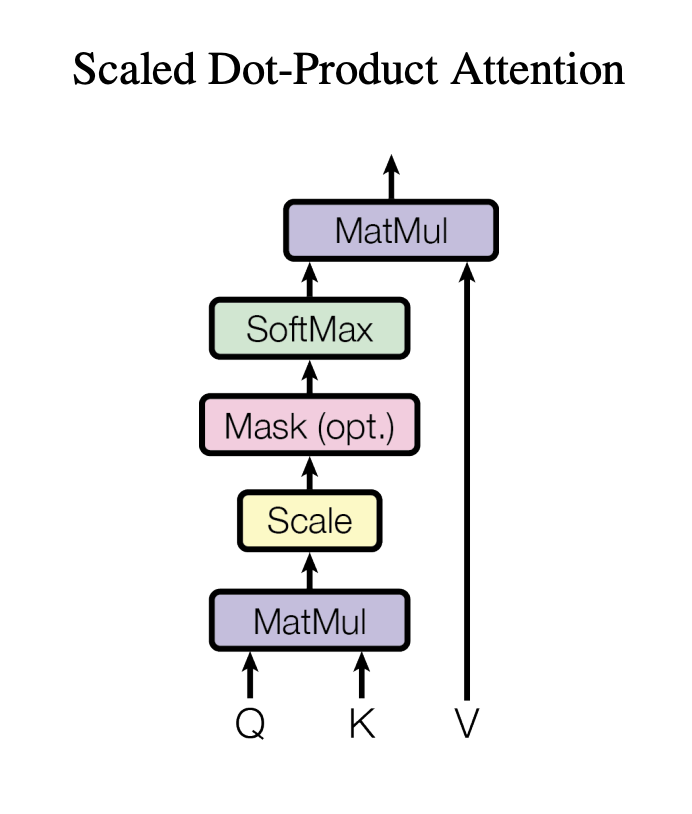

In [ ]:
torch.manual_seed(1337)
B,T,C = 4, 8, 32
x = torch.randn(B, T, C)

# let's see a single head perform self-attention
head_size = 16

# (from the YT video) Typically people don't use bias.
key = nn.Linear(in_features=C, out_features=head_size, bias=False)
query = nn.Linear(in_features=C, out_features=head_size, bias=False)

k = key(x)  # (B, T, head_size=16)
q = query(x)  # (B, T, head_size=16)
wei = q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) ----> (B, T, T)

tril = torch.tril(torch.ones(T, T))

# This line is deleted for the "encoder" style block so that the token can
# communicate with the ones afterwards.
wei = wei.masked_fill(tril==0, float('-inf'))

# Normalize the weight. See the section below for details.
wei = wei * head_size**-0.5

wei = F.softmax(wei, dim=-1)

value = nn.Linear(in_features=C, out_features=head_size, bias=False)
v = value(x) # (B, T, head_size=16)

out = wei @ v # (B, T, T) @ (B, T, 16) ----> (B, T, 16)


out.shape

torch.Size([4, 8, 16])

In [ ]:
print(f'tril = {tril}')
print(f'wei = {wei}')

tril = tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])
wei = tensor([[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.3966, 0.6034, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.3069, 0.2892, 0.4039, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.3233, 0.2175, 0.2443, 0.2149, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1479, 0.2034, 0.1663, 0.1455, 0.3369, 0.0000, 0.0000, 0.0000],
         [0.1259, 0.2490, 0.1324, 0.1062, 0.3141, 0.0724, 0.0000, 0.0000],
         [0.1598, 0.1990, 0.1140, 0.1125, 0.1418, 0.1669, 0.1061, 0.0000],
         [0.0845, 0.1197, 0.1078, 0.1537, 0.1086, 0.1146, 0.1558, 0.1553]],

        [[1.0000, 0.0000, 0.0000, 0.0000, 0.0000

## Notes

1. Attention is a **communication mechanism**. Can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.

2. There is no notion of space. Attention simply acts over a set of vectors. This is why we need to **positionally** encode tokens.

3. Each example across *batch dimention* is of cource processed completedly independently and never "talk" to each other.

4. In an "enncoder" attention block just delete the single line that does masking with `tril`, allowing all tokens to communicate. This block here is called a "decoder" attention block because it has trianglar masking, and is usually used in autoregressive settings, like language modeling.

5. "self-attention" just means that the keys and values are produced from the same source as queries. In "cross-attention", the queries still get producted from x, but the key and values comes from some other, external source (e.g. an encoder module)

6. "Scaled" attention additionally divides `wei` by 1/sqrt(head_size). This makes it so when input Q,K are unit variance, `wei` will be unit variance too and `Softmax` will stay diffuse and not saturate too much. (see the section below)

### Scaled Attention

In the Attention paper, a scaling factor is added. This is because the `Q @ K` has a variation closed to `head_size` (dk in the paper). A large variation causes the softmax to get extreme values (0 or 1, similar to one-hot) and small gradient, which is not a good weight initialization and not good for model training, and causes the attention to focus on one single token, instead of spreading out. By adding the scaling factor, it reduces the variation closed to 1.

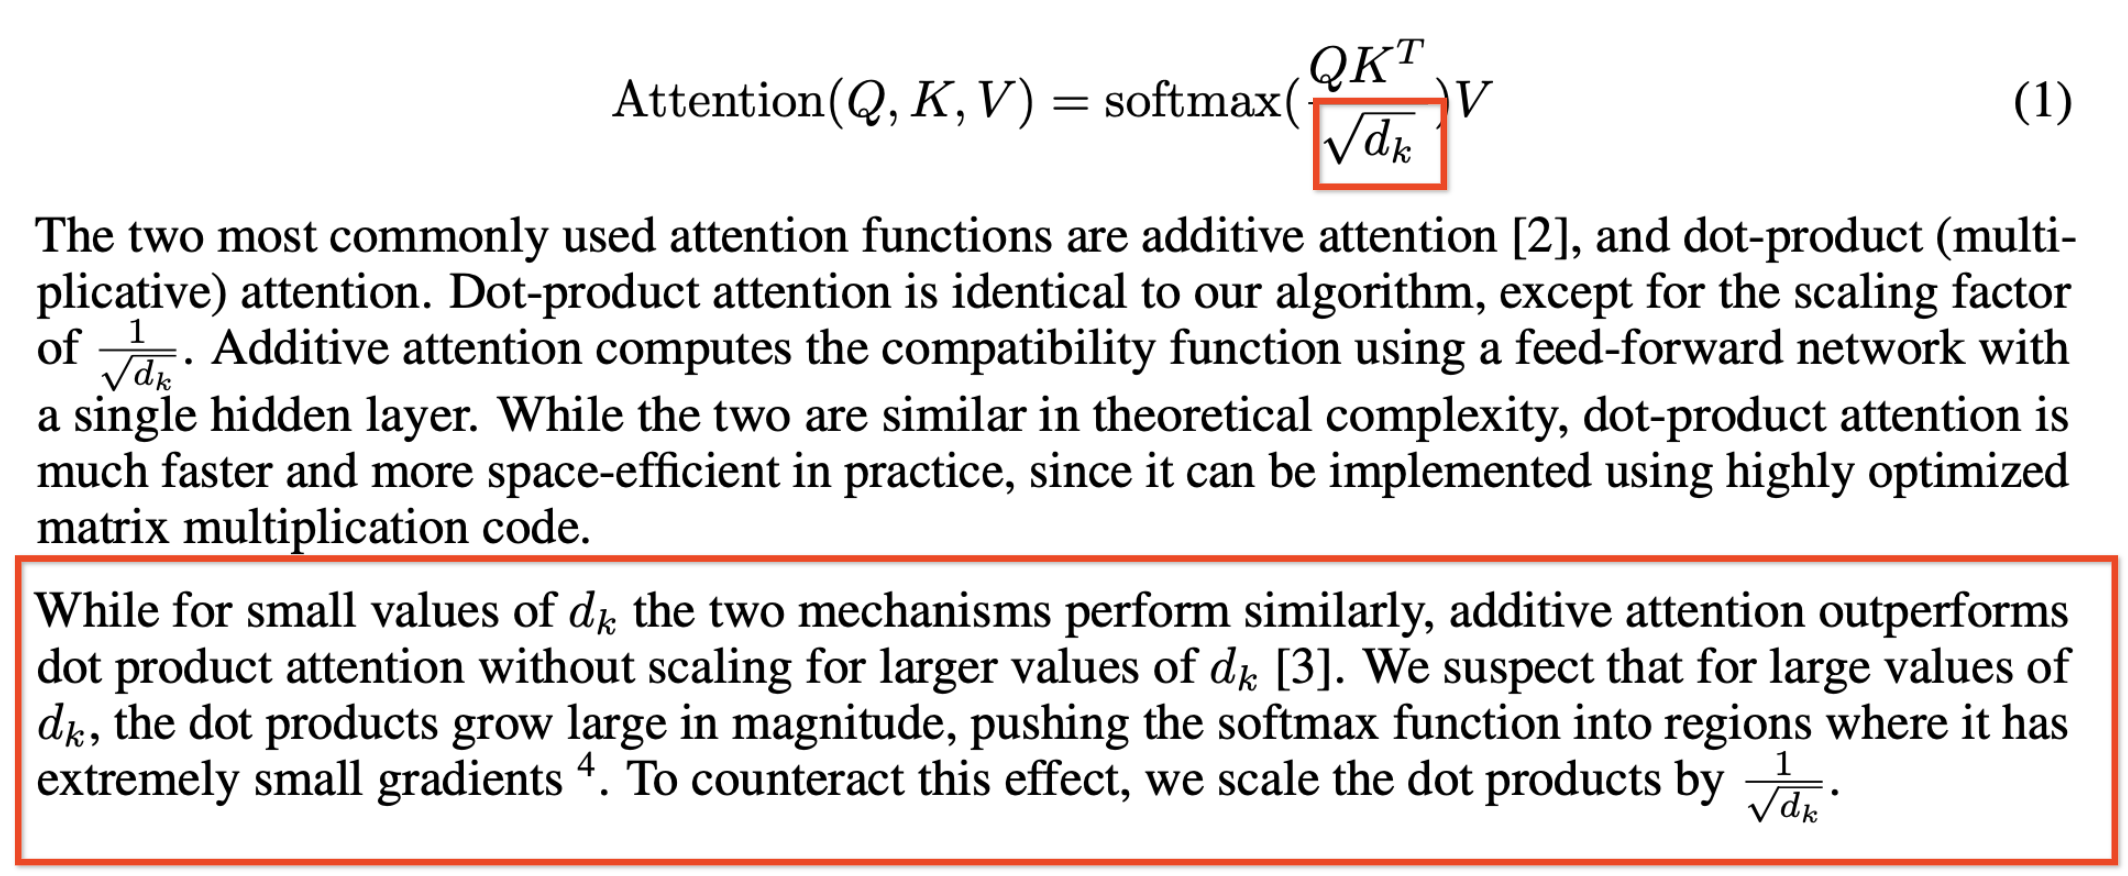

- This part of code demonstrate the effect of the scaling factor

In [ ]:
k = torch.randn(B, T, head_size)
q = torch.randn(B, T, head_size)
wei = q @ k.transpose(-2, -1)
normalized_wei = wei * head_size**-0.5
print(f'k var = {k.var()}\nv var = {v.var()}\nun-normalized wei var = {wei.var()}\nnormalized wei var = {normalized_wei.var()}')

k var = 1.044861912727356
v var = 0.345710426568985
un-normalized wei var = 17.46897315979004
normalized wei var = 1.0918108224868774


## Improve training efficiency

1. Skip (residual) connection
2. Layer Norm.
- TF structure doesn't have many changes in the last few years. One change is the layer norm. In the paper, it happens after the Attention or FF block. Now it is very common to apply it before the Attention or FF block. This is called **pre-norm formulation**.

# Misc

1. The FFN after attention: the attention make the tokens to communicate with each other, but it doesn't have time to think about it. The FFN adds the stage for the thinking.

2. Dropout: it shuts down some nodes randomly during training. It can be thought of as to formulate several individual networks. During inference, all networks are enabled.

3. For the NanoGPT and roughly what we implemented in this colab, it is the decoder part of the Attention paper without the cross-attention.
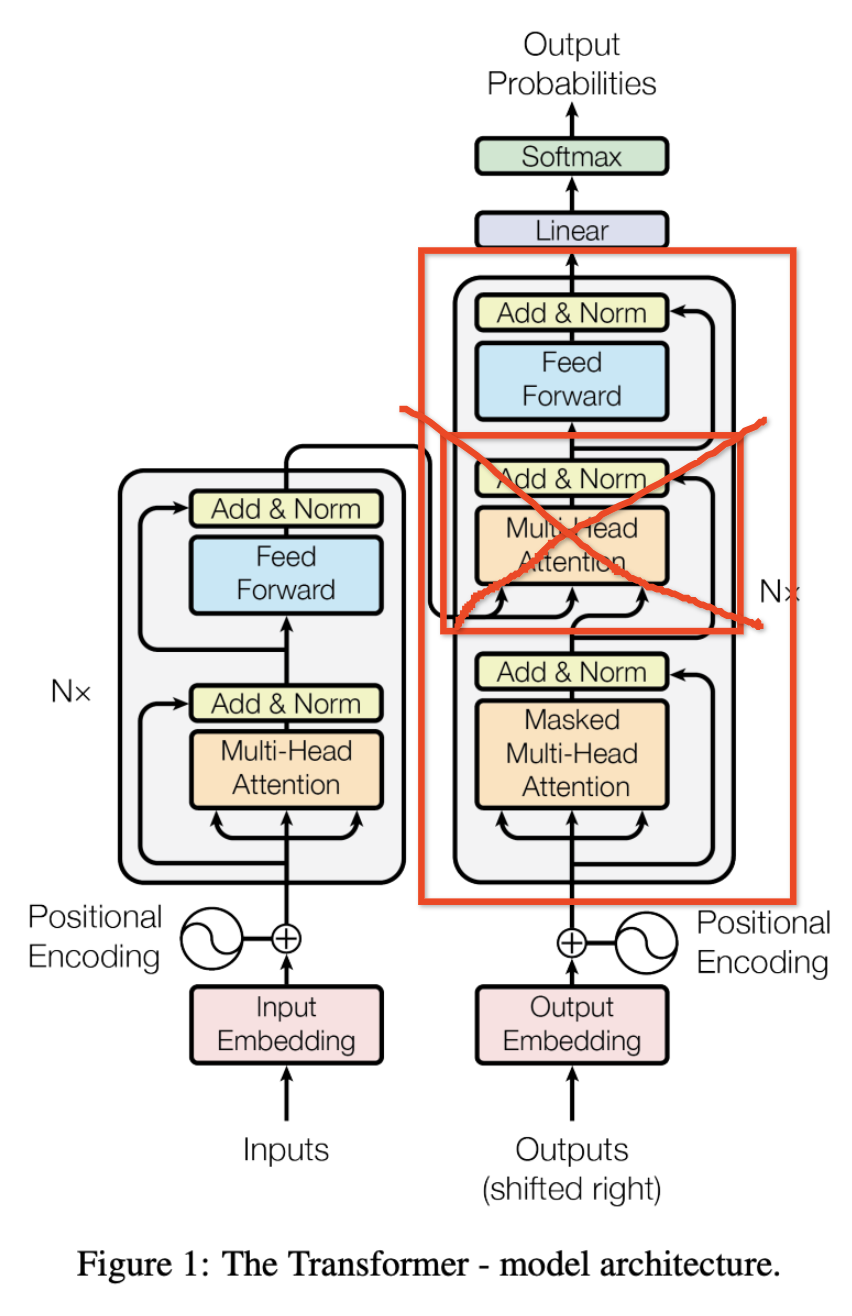

4. The original Attention paper has an encoder because it deals with translation problem, and it would need to use the endcoder to capture the source text as context.

5. In the NanoGPT, it treats the multi-head as a standalone dimension at 2nd dim. In the current impl, it doesn't treat it as a standalone dim and explicitly does `concat`. The two approaches are mathematically the same; while the NanoGPT implementation is more efficient because it push the head to "batch dimension"

6. In the GPT-3 paper, the notion is the same as we use in this colab. Note d_model is n_emb in this colab; it equals n_head * d_head, because the number of embedding is considered to the the sum of each head's embedding.


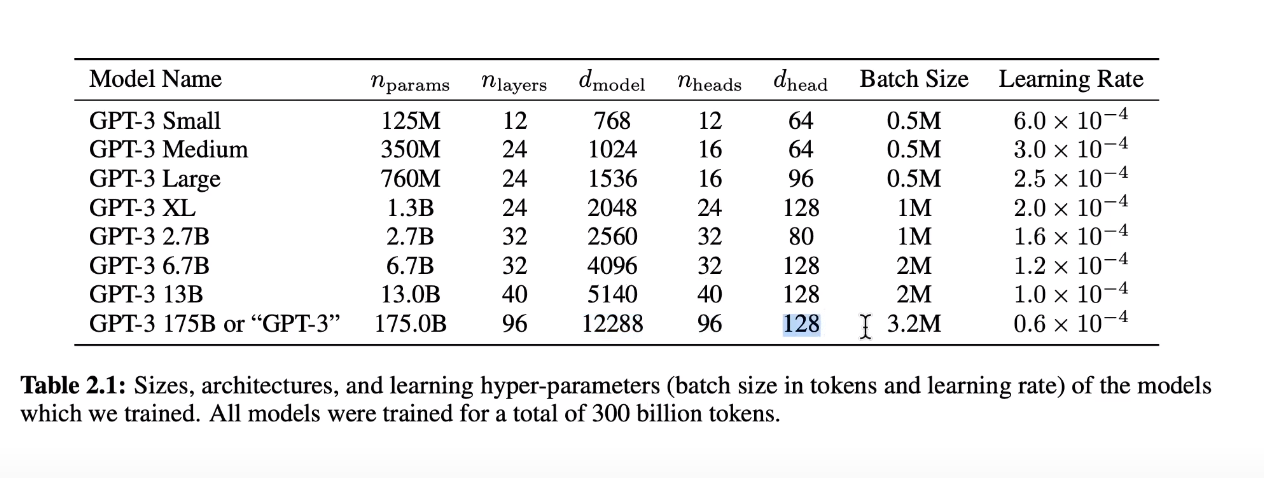

7. The GPT-3 architecture is similar to what we have here in the colab. Of course the training infra is a big challenge, where  it needs to use thousands of GPU.

8. The colab focuses on ptr-training. The model is like a doc completer. If any task that is different than doc completer, you either need to do simple fine-tuning,or more complicated FT like OpenAI including training a reward model and PPO strategy to improve the model based on the reward model.